In [36]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import uuid
import cv2
from PIL import Image
import tensorflow as tf
# import tensorflow_io as tfio

# from pydicom import dcmread 

from duke_dbt_data import dcmread_image,draw_box

In [2]:
# rootdir = 'D:\MRI dataset\manifest-1617905855234\Breast-Cancer-Screening-DBT'
#WINDOWS
# rootdir = R'C:\Users\016103631\Desktop\MRI dataset\manifest-1617905855234\Breast-Cancer-Screening-DBT'

# destination = 'D:\MRI dataset\data\\train'
# destination = R'C:\Users\016103631\Desktop\MRI dataset\train'
############
#MAC
rootdir = '/Volumes/My Passport/MRI dataset/manifest-1617905855234/'
destination = '/Users/lucas.wojahn/Documents/GitHub/duke-dbt-data/data/train/'
############

In [9]:
def merge_datasets(source: str):
    df_paths = pd.read_csv("file-paths copy.csv")
    df_labels = pd.read_csv("labels-train.csv")
    df_boxes = pd.read_csv("BCS-DBT boxes-train-v2.csv")
    df_true = df_paths.merge(df_labels, how='inner')
    df_true = df_true.merge(df_boxes, how='inner')
    df_true['descriptive_path'] = source + df_true['descriptive_path'].astype(str)
    df_paths['descriptive_path'] = source + df_paths['descriptive_path'].astype(str)

    #WINDOWS
    #df_true['descriptive_path'] = df_true['descriptive_path'].str.replace('/',R'\\')
    #MAC
    df_true['descriptive_path'] = df_true['descriptive_path']
    df_true[(df_true[['Cancer','Benign','Actionable']] == 1).any(axis=1)]
    print(f"X:{df_true['X'][0]}, Y:{df_true['Y'][0]}, Width:{df_true['Width'][0]}, Height:{df_true['Height'][0]}")

    ##REMOVENDO TRUE POSITIVE DO DATASET PATH PARA FILTRAR IMAGENS SEM LABEL
    df_regular = df_paths[~df_paths['PatientID'].isin(df_true['PatientID'])]
    
    return df_true,df_regular 



X:1116, Y:1724, Width:218, Height:105
DBT-P00013
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
X=1116
Y=1724
1890
2457
Normalized x 0.5904761904761905
Normalized y 0.7016687016687017
Normalized width 0.11534391534391535
Normalized height 0.042735042735042736


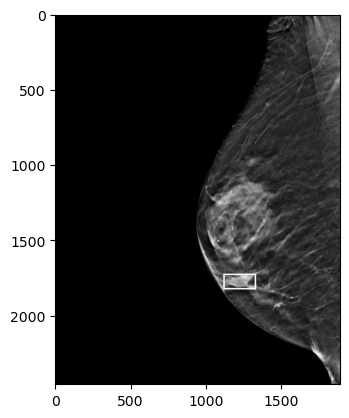

In [40]:
def write_annotation_file(
    image: np.ndarray,
    df: pd.DataFrame
    ):

    # LEMBRA DE TROCAR A PORRA DO [0] FIXO NO DATAFRAME
    img_width, img_height = df['Width'][0], df['Height'][0]
    X, Y = df['X'][0], df['Y'][0]

    print(f'X={X}')
    print(f'Y={Y}')

    total_image_height = image.shape[0]
    total_image_width =  image.shape[1]

    normalized_x = X/total_image_width
    normalized_y = Y/total_image_height
    normalized_width = img_width/total_image_width
    normalized_height = img_height/total_image_height

    print(total_image_width)
    print(total_image_height)

    print(f'Normalized x {normalized_x}')
    print(f'Normalized y {normalized_y}')
    print(f'Normalized width {normalized_width}')
    print(f'Normalized height {normalized_height}')
  

    annotation_file = 'teste.txt'

    f = open('test/'+annotation_file, "w")

    if row['Benign'][0] == 1:
        classe = 0
    elif row['Cancer'][0] == 1:
        classe = 1
    elif row['Actionable'][0] == 1:
        classe = 2

    if classe is not None:
        f.write(f"{classe} {normalized_x} {normalized_y} {normalized_width} {normalized_height}")

    f.close()

    image_box = draw_box(image=image, 
        x=int(normalized_x*1890), 
        y=int(normalized_y*2457), 
        width=int(normalized_width*1890), 
        height=int(normalized_height*2457), 
        lw=10
    )
    plt.imshow(image_box, cmap=plt.cm.gray)

df_true, df_regular = merge_datasets('data/TP/')
row = df_true
print(str(row['PatientID'][0]))
name = str(row['PatientID'][0])
slice_index = row['Slice'][0]

    # MAC
split = row['descriptive_path'][0].split('/')
split[-2] = split[-2].replace('-', '-NA-')
path = '/'.join(split)
view = row["View"][0]
image = dcmread_image(fp=path, view=view, index=slice_index)
# image = dcmread_image(fp=path, view=view)
print(type(image))
print(type(row))

plt.imsave('test/teste.jpg', image,  format="jpg", cmap=plt.cm.gray)
write_annotation_file(image=image,df=row)
# plt.imshow(image, cmap=plt.cm.gray)



In [4]:
import concurrent.futures

rootdir = '/Volumes/My Passport/MRI TP images/manifest-1677805544485/'
destination = '/Users/lucas.wojahn/Documents/GitHub/duke-dbt-data/data/train2/'

##NÃO ESQUECE DE PASSAR O SLICE_INDEX (AUMENTA A QUALIDADE)

def process_image(path, 
    view, 
    slice_index, 
    destination, 
    annotation_file,
    row
):
    image = dcmread_image(fp=path, view=view, index=slice_index)
    plt.imsave(destination+'/'+annotation_file, image,  format="jpg", cmap=plt.cm.gray)
    write_annotation_file(image=image,df=row)
    return annotation_file

def write_annotation_file(
    image: np.ndarray,
    df: pd.DataFrame
    ):

    # LEMBRA DE TROCAR A PORRA DO [0] FIXO NO DATAFRAME
    img_width, img_height = df['Width'], df['Height']
    X, Y = df['X'], df['Y']

    total_image_height = image.shape[0]
    total_image_width =  image.shape[1]

    normalized_x = X/total_image_width
    normalized_y = Y/total_image_height
    normalized_width = img_width/total_image_width
    normalized_height = img_height/total_image_height
  
    annotation_file = 'teste.txt'

    f = open('test/'+annotation_file, "w")

    if row['Benign'][0] == 1:
        classe = 0
    elif row['Cancer'][0] == 1:
        classe = 1
    elif row['Actionable'][0] == 1:
        classe = 2

    if classe is not None:
        f.write(f"{classe} {normalized_x} {normalized_y} {normalized_width} {normalized_height}")

    f.close()


def process_TP(source: str, destino: str):

    df_true, df_regular = merge_datasets(source)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for index, row in df_true.iterrows():
            #NOMEANDO ARQUIVOS
            name = str(row['PatientID'])
            slice_index = row['Slice']
            uuid_name = str(uuid.uuid4())
            annotation_file = name+'-'+uuid_name+'.txt'

            # MAC
            split = row['descriptive_path'].split('/')
            split[-2] = split[-2].replace('-','-NA-')
            path = '/'.join(split)
            view = row["View"]

            futures.append(executor.submit(process_image, path, view, slice_index, destino, annotation_file, row))
            for future in concurrent.futures.as_completed(futures):
                try:
                    result = future.result()
                except Exception as e:
                    print(f"Exception: {e}")

    df_true.drop(index, inplace=True)

process_TP(source=rootdir,destino=destination)


229, 186,939, 1469
0.24387646432374868, 0.12661674608577264,1.2438764643237488, 1.1266167460857726


In [ ]:
##PROCESSA IMAGENS QUE NÃO POSSUEM TRUE POSITIVE
def processa_normal(source: str, destino: str):

    df_true, df_paths = merge_datasets(source)

    for index, row in df_paths.iterrows():
        name = str(row['PatientID'])
        uuid_name = str(uuid.uuid4())
        annotation_file = name+'-'+uuid_name+'.jpg'
        split = row['descriptive_path'].split('/')
        split[-2] = split[-2].replace('-','-NA-')
        path = '/'.join(split)
        view = row["View"]
        image = dcmread_image(fp=path, view=view)
        plt.imsave(destination+'/'+annotation_file, image[0],  format="jpg", cmap=plt.cm.gray)
        df_paths.drop(index, inplace=True)
        
processa_normal(source=rootdir,destino=destination)


In [ ]:
####ADICIONANDO MULTITHREAD A FUNÇÃO
import concurrent.futures

df_true, df_paths = merge_datasets(rootdir)

def process_image(path, view, destination, annotation_file):
    image = dcmread_image(fp=path, view=view)
    plt.imsave(destination+'/'+annotation_file, image[0],  format="jpg", cmap=plt.cm.gray)
    return annotation_file

def processa_normal(source: str, destino: str):

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for index, row in df_paths.iterrows():
            name = str(row['PatientID'])
            uuid_name = str(uuid.uuid4())
            annotation_file = name+'-'+uuid_name+'.jpg'
            split = row['descriptive_path'].split('/')
            split[-2] = split[-2].replace('-','-NA-')
            path = '/'.join(split)
            view = row["View"]
            futures.append(executor.submit(process_image, path, view, destino, annotation_file))
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
            except Exception as e:
                print(f"Exception: {e}")
    df_paths.drop(index, inplace=True)

processa_normal(source=rootdir,destino=destination)

In [ ]:
from PIL import Image, ImageDraw

# Load the image
image = Image.open('example.jpg')

# Create a rectangle object with the desired coordinates
x, y, width, height = 100, 100, 200, 300
bbox = (x, y, x+width, y+height)

# Draw the bounding box on the image
draw = ImageDraw.Draw(image)
draw.rectangle(bbox, outline='red')

# Save the modified image
image.save('example_bbox.jpg')

In [ ]:
process_TP(source=rootdir,destino=destination)
processa_normal(source=rootdir,destino=destination)

In [ ]:
# rootdir = 'D:\MRI dataset\manifest-1617905855234\Breast-Cancer-Screening-DBT'
rootdir = R'C:\Users\016103631\Desktop\MRI dataset\manifest-1617905855234\Breast-Cancer-Screening-DBT'

# destination = 'D:\MRI dataset\data\\train'
destination = R'C:\Users\016103631\Desktop\MRI dataset\train'
def mv_dcm_files(dirpath, filetype):
    paths = []
    for rootdir, dirs, files in os.walk(dirpath):      
        for id in dirs:
            print(id)
            value = df_true.loc[df_true['PatientID'] == id]
            if not value.empty:
                new_path = dirpath + '\\'+id
                n_file = 0
                for rootdir, dirs, files in os.walk(new_path):
                    # if n_file == 0:
                    #     print(rootdir)
                    #     print(value)
                    for file in files:
                        if file.lower().endswith(filetype.lower()):
                            filepath = os.path.join(rootdir, file)
                            print("TO AQUI DENTRO")
                            name = str(value['PatientID'][0])
                            uuid_name = str(uuid.uuid4())
                            annotation_file = name+'-'+uuid_name+'.txt'
                            
                            classe = None
                            print(f"TESTE {value['Benign'][0]}")
                            if 1 in value['Benign']:
                                classe = 0
                                # shutil.move(filepath, destination+'\\Benign\\'+name+'-'+uuid_name+'.dcm')
                            elif 1 in value['Cancer']:
                                classe = 1
                                # shutil.move(filepath, destination+'\\Cancer\\'+name+'-'+uuid_name+'.dcm')
                            elif 1 in value['Actionable']:
                                classe = 2
                                # shutil.move(filepath, destination+'\\Cancer\\'+name+'-'+uuid_name+'.dcm')
                            # else:
                            #     shutil.move(filepath, destination+'\\Normal\\'+name+'-'+uuid_name+'.dcm')

                    n_file+=1


                    # filepath = filepath.strip(R'D:\\MRI dataset\\manifest-1617905855234')
                            # paths.append(filepath)
    return paths

mv_dcm_files(rootdir, '.dcm')

In [ ]:
view_series = df.iloc[0]
view = view_series["View"]
# if you have image data saved in classic path folder structure, read the file path from "classic_path"
# image_path = os.path.join("/data", view_series["classic_path"])
image_path = os.path.join("/data", view_series["descriptive_path"])


In [ ]:
# %%time
# image = dcmread_image(fp='1-1.dcm', view=view)

In [ ]:
plt.imshow(image[0], cmap=plt.cm.gray);